In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier

import data_prep as dp

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = \
    dp.X_train, dp.X_val, dp.X_test, dp.y_train, dp.y_val, dp.y_test
# DictionaryVectorizer
dv = dp.dv

features = dv.get_feature_names()
# matrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Decision Tree final model

In [4]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

Random Forest final model

In [5]:
rf = RandomForestClassifier(n_estimators=90,
                            max_depth=10, 
                            min_samples_leaf=3,
                            random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=90,
                       random_state=42)

XGBoost final model

In [6]:
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3,
    'min_child_weight': 30, # min_samples_leaf

    'objective': 'binary:logistic', # specify that we have a binary classification model
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1 # show the process 0, 1, 2
}
model = xgb.train(xgb_params, dtrain, num_boost_round=155)

Check models performance on validation set

In [8]:
# decision tree
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7854738320699426

In [9]:
# random forest
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8286945096994501

In [11]:
# xgboost
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8372435881911312

Train the best model on the full train data (train + validation)

In [16]:
X_train.shape

(2672, 29)

In [19]:
X_train.shape[0] + X_val.shape[0]

3563

In [18]:
np.append(X_train, X_val, axis=0).shape

(3563, 29)

In [20]:
X_full = np.append(X_train, X_val, axis=0)

In [22]:
# check if correct
X_full[0] == X_train[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [23]:
X_full[2671] == X_train[-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [24]:
X_full[2672] == X_val[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [29]:
np.append(y_train, y_val).shape

(3563,)

In [30]:
y_full = np.append(y_train, y_val)

In [32]:
# check if correct
y_full[0] == y_train[0],\
    y_full[2671] == y_train[-1],\
        y_full[2672] == y_val[0]

(True, True, True)

In [33]:
dfull = xgb.DMatrix(X_full, label=y_full, feature_names=features)
dtest = xgb.DMatrix(X_test, feature_names=features)

In [34]:
model = xgb.train(xgb_params, dfull, num_boost_round=155)
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8333659156443967

#### Feature importance

__Decision Tree__

In [36]:
list(zip(dv.feature_names_, dt.feature_importances_))[:5]

[('age', 0.013877231876069155),
 ('amount', 0.04793733336664825),
 ('assets', 0.1226385042392285),
 ('debt', 0.008332876385504904),
 ('expenses', 0.02509060257588133)]

In [37]:
importances = list(zip(dv.feature_names_, dt.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance.head()

,feature,gain
25,records=no,0.244217
12,income,0.187248
16,job=partime,0.172928
2,assets,0.122639
27,seniority,0.121522


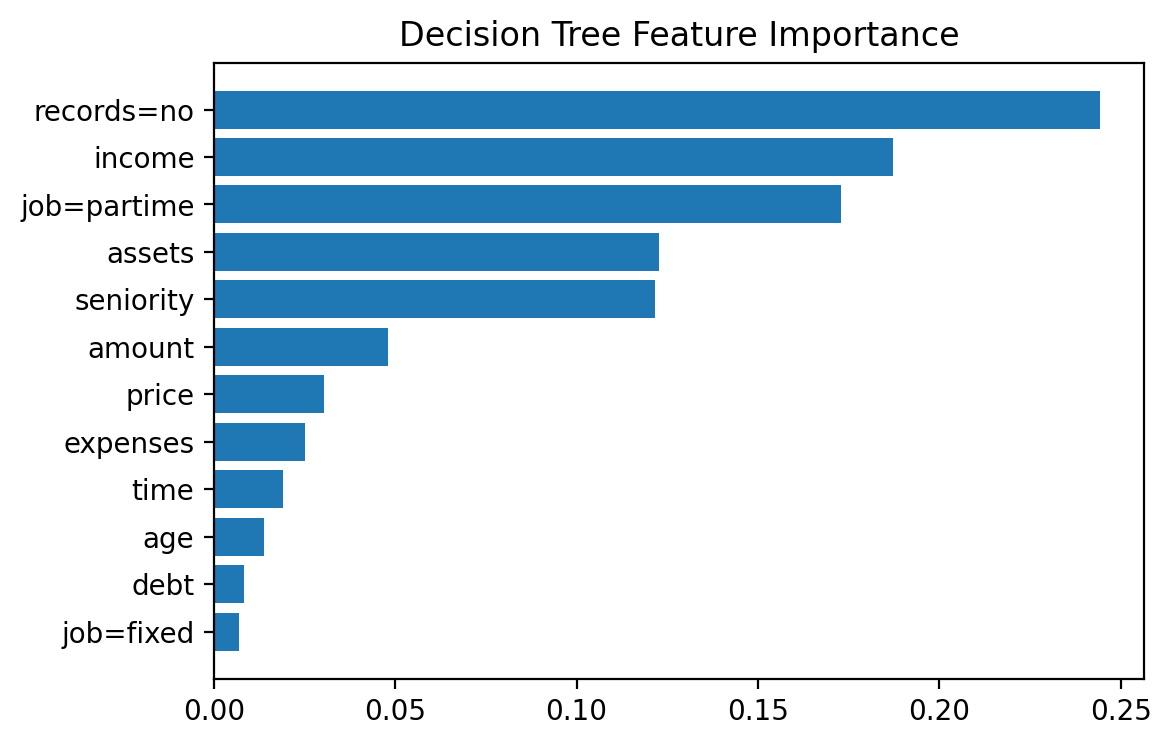

In [42]:
df_importance = df_importance[df_importance.gain > 0]

num = len(df_importance)
plt.figure(figsize=(6,4))
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])
plt.title('Decision Tree Feature Importance')
plt.show()

__Random Forest__

In [43]:
rf.feature_importances_

array([6.13683047e-02, 8.55904553e-02, 7.89691367e-02, 1.67222024e-02,
       4.40697542e-02, 8.08934127e-05, 6.31760346e-03, 2.23997290e-02,
       9.10130826e-03, 3.81269365e-03, 1.39482205e-02, 0.00000000e+00,
       1.45959970e-01, 3.90050859e-02, 1.05158449e-02, 2.90727044e-03,
       6.05757346e-02, 0.00000000e+00, 3.28667203e-04, 7.50486939e-03,
       2.41768016e-03, 6.35254645e-03, 0.00000000e+00, 2.41154196e-04,
       7.81916624e-02, 6.84070214e-02, 8.14299901e-02, 1.20434638e-01,
       3.33475641e-02])

In [46]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False).reset_index(drop=True)
df_importance

,feature,gain
0,income,0.145960
1,seniority,0.120435
2,amount,0.085590
3,records=yes,0.081430
4,assets,0.078969
5,price,0.078192
6,records=no,0.068407
7,age,0.061368
8,job=partime,0.060576
9,expenses,0.044070


In [47]:
df_importance = df_importance[:12]
df_importance

,feature,gain
0,income,0.145960
1,seniority,0.120435
2,amount,0.085590
3,records=yes,0.081430
4,assets,0.078969
5,price,0.078192
6,records=no,0.068407
7,age,0.061368
8,job=partime,0.060576
9,expenses,0.044070


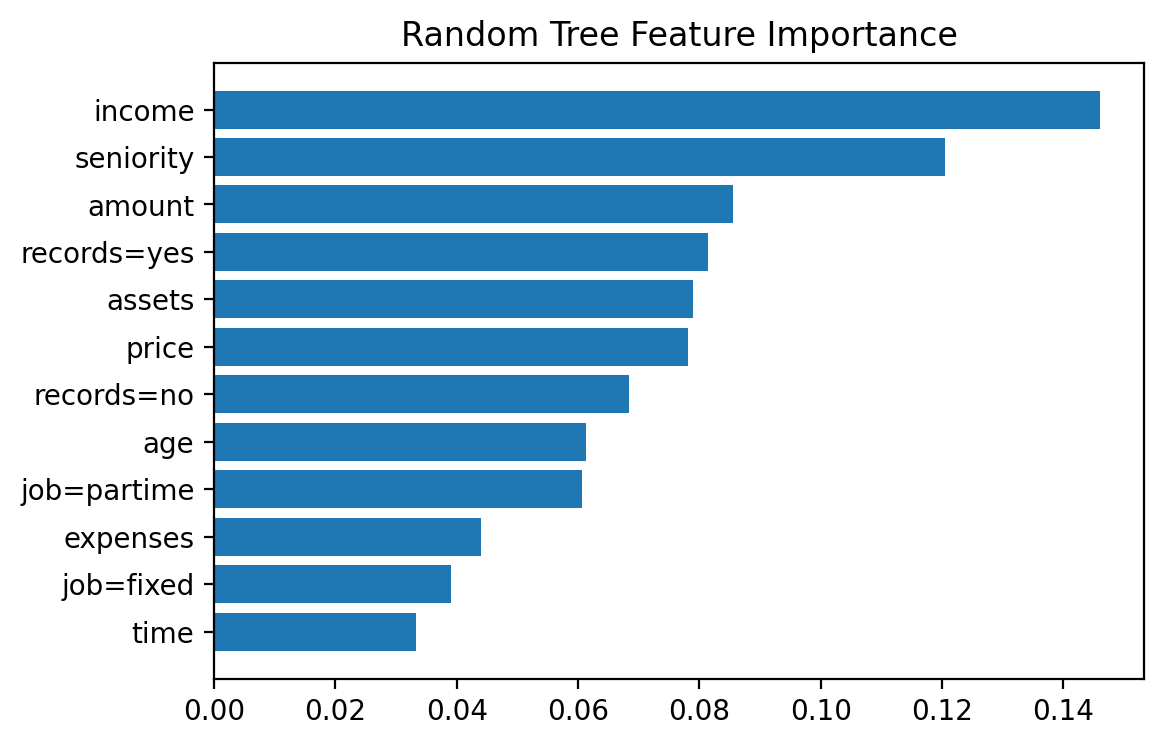

In [48]:
num = len(df_importance)
plt.figure(figsize=(6,4))
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])
plt.title('Random Tree Feature Importance')
plt.show()

__XGBoost__

Importance = `gain`

In [54]:
scores = model.get_score(importance_type='gain')
scores

{'age': 3.0760610103607178,
 'amount': 9.319397926330566,
 'assets': 12.252556800842285,
 'debt': 3.500457525253296,
 'expenses': 4.495729923248291,
 'home=other': 3.3268680572509766,
 'home=owner': 9.589973449707031,
 'home=parents': 6.4632978439331055,
 'income': 14.832683563232422,
 'job=fixed': 16.10487174987793,
 'job=partime': 27.472192764282227,
 'marital=married': 1.9963184595108032,
 'price': 4.452285289764404,
 'records=no': 30.140893936157227,
 'seniority': 21.00675392150879,
 'time': 9.75851821899414}

In [55]:
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('records=no', 30.140893936157227),
 ('job=partime', 27.472192764282227),
 ('seniority', 21.00675392150879),
 ('job=fixed', 16.10487174987793),
 ('income', 14.832683563232422),
 ('assets', 12.252556800842285),
 ('time', 9.75851821899414),
 ('home=owner', 9.589973449707031),
 ('amount', 9.319397926330566),
 ('home=parents', 6.4632978439331055),
 ('expenses', 4.495729923248291),
 ('price', 4.452285289764404),
 ('debt', 3.500457525253296),
 ('home=other', 3.3268680572509766),
 ('age', 3.0760610103607178),
 ('marital=married', 1.9963184595108032)]

Importance = `weight`

In [56]:
scores = model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('price', 119.0),
 ('income', 100.0),
 ('amount', 99.0),
 ('seniority', 66.0),
 ('expenses', 62.0),
 ('assets', 62.0),
 ('age', 55.0),
 ('records=no', 49.0),
 ('debt', 29.0),
 ('job=fixed', 22.0),
 ('home=parents', 20.0),
 ('job=partime', 19.0),
 ('time', 18.0),
 ('marital=married', 16.0),
 ('home=owner', 10.0),
 ('home=other', 7.0)]

In [57]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

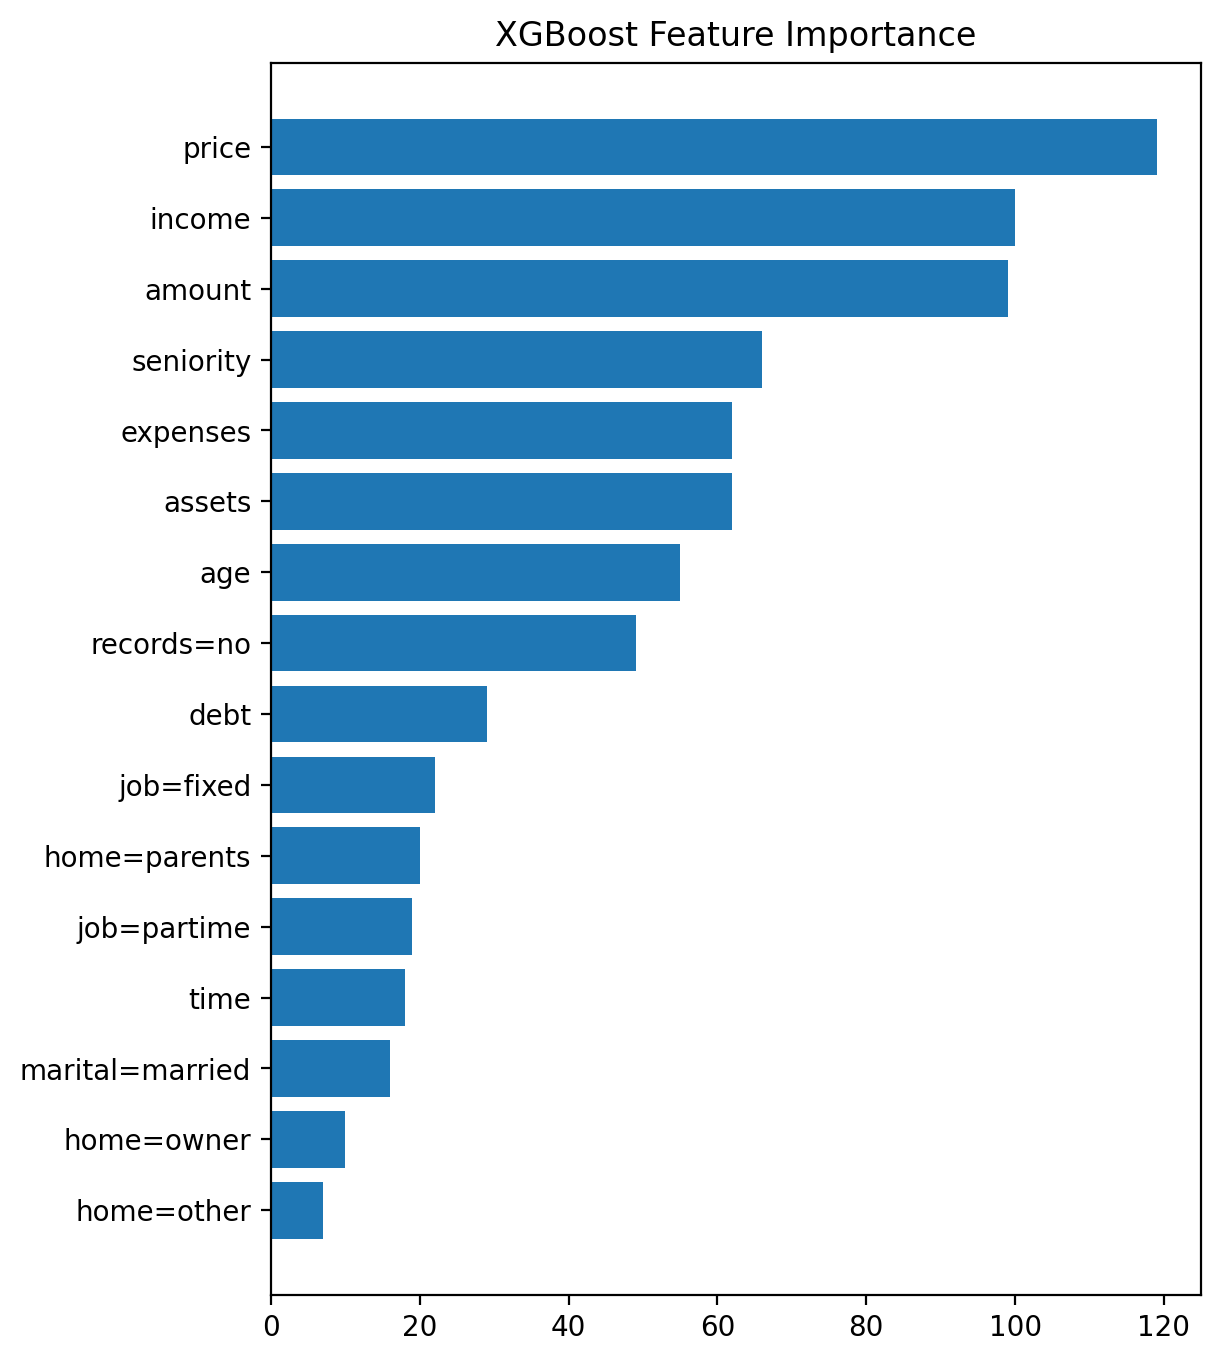

In [59]:
plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)
plt.title('XGBoost Feature Importance')
plt.show()

#### Extremely randomized trees
Never overfit! Similar to random forest, but more random. Instead of selecting the best split among all posible splits, ET picks a few candidate splits at random and then select the best one among them.

In [61]:
aucs = []

from sklearn.ensemble import ExtraTreesClassifier

for i in range(10, 201, 10):
    etc = ExtraTreesClassifier(n_estimators=i, max_depth=30)
    etc.fit(X_train, y_train)
    y_pred = etc.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

10 -> 0.778
20 -> 0.790
30 -> 0.802
40 -> 0.777
50 -> 0.797
60 -> 0.786
70 -> 0.787
80 -> 0.792
90 -> 0.788
100 -> 0.791
110 -> 0.794
120 -> 0.789
130 -> 0.796
140 -> 0.797
150 -> 0.801
160 -> 0.799
170 -> 0.796
180 -> 0.797
190 -> 0.792
200 -> 0.797


30 estimators show the best result, it is worse than Random Forest and XGBoost results.

#### Notes

* "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier.
* __XGBoost can deal with NAs__ - we don't have to do fillna for it. Check if not filling NA's help improve performance.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. 
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for `XGBoost`.  
